In [5]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re,string,unicodedata
from collections import Counter

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns

import contractions 

from sklearn import metrics 
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
nltk.download()
nltk.download('stopwords')

lista_stopwords = set(stopwords.words('english'))
punctuation = list(string.punctuation)
lista_stopwords.update(punctuation)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gdutr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def mostra_relacao_ngrams_sentimento(features, feature_names, labels, labels_dict, ngrams=3, N=3):
    
    for sentiment, sentiment_id in sorted(labels_dict.items()):
        features_chi2 = chi2(features, labels == sentiment_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(feature_names)[indices] # vectorizer.get_feature_names()
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    
        print("# '{}':".format(sentiment))
        print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
        print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
        print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

### Rotina Pré-Processamento (Representação por Frequência)

In [8]:
# separa tokens de acordo com os parâmetros informados
def split_tokens_word_freq(texto, vocab, use_twitter_tokenizer,use_lemmatizer):
    lemmatizer = WordNetLemmatizer()
    
    texto = texto.lower()
    texto = contractions.fix(texto)    
    
    if use_twitter_tokenizer:
        tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
        lista_tokens_inicial = tokenizer.tokenize(texto)
    else:
        lista_tokens_inicial = word_tokenize(texto)
    
    lista_tokens = []
    for token in lista_tokens_inicial:
        add_token = True
        
        if use_lemmatizer:
            token = lemmatizer.lemmatize(token)
        
        if (token  in lista_stopwords):
            add_token = False
        if vocab is not None and token not in vocab:
            add_token = False
        
        if add_token:
            lista_tokens.append(token)
    
    
    return lista_tokens

In [9]:
# Limpeza do texto através de Expressões Regulares
def limpa_texto(texto):
    # link
    texto = re.sub('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', texto)
    # numero string com números não estamos retirando inicialmente (COVID-19)
    texto = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'number', texto)
    texto = re.sub(r'\s+', ' ', texto)
    return texto

In [10]:
#Labels. Pemite agrupar negativos e positivos
def get_labels_dict(lista_sentimentos, agrupar_labels):
    if not agrupar_labels:
        return {'Extremely Negative': -2 , 'Negative': -1, 'Neutral': 0, 'Positive': 1, 'Extremely Positive': 2}
    else:
        return {'Negative': -1 ,'Neutral': 0, 'Positive': 1}
    
    

In [11]:
# Carrega o arquivo de vocabulário
def carrega_vocabulario(file_name='glove.6B.100d.txt'):
    with open(file_name,'r', encoding="utf8") as f:
        word_vocab = set()
        
        for line in f:
            line_ = line.strip() 
            v = line_.split()[0]            
            word_vocab.add(v)
            
    return word_vocab

In [35]:
# Separa o texto em tokens, retornando um nparray
def carrega_tokens_word_freq(lista_texto, use_twitter_tokenizer, use_vocabulario, use_lemmatizer):
    if use_vocabulario:
        vocab = carrega_vocabulario()    
    else:
        vocab = None
        
    feature_tokens = []
    for texto in lista_texto:
        texto_limpo = limpa_texto(texto)
        tokens_add = split_tokens_word_freq(texto_limpo, 
                                            vocab=vocab, 
                                            use_twitter_tokenizer=use_twitter_tokenizer, 
                                            use_lemmatizer=use_lemmatizer)
        feature_tokens.append(tokens_add)

    feature_tokens = np.asarray(feature_tokens)
    return feature_tokens

In [34]:
# Retorna as palavras que aparecem nos diferentes labels, possuindo uma frequencia minima
def get_word_frequency_by_label(min_frequency, features, labels, label_filter):
    
    vet = [features[i] for i,l in enumerate(labels) if l == label_filter ]
    word_list = [word for list_token in vet for word in list_token ]
    counter = Counter(word_list)
    top_list = counter.most_common(20)
    min_freq = int(len(vet) * min_frequency)
    lista_min_freq =[]
    
    for t in top_list:
        cont = 0
        for item in vet:            
            if t[0] in item:
                cont+=1
            if cont >= min_freq:
                if t[0] not in lista_min_freq:
                    lista_min_freq.append(t[0])
    return lista_min_freq

In [14]:
# Retorna um conjunto de palavras que pode ter pouco impacto ou negativo na analise por ter alta frequencia e aparecer em todos os labels
def get_words_with_lower_impact(min_frequency, features, labels, label_dict):
    
    list_by_label = {}
    retorno = []
    
    for l in label_dict:
        list_by_label[l] = get_word_frequency_by_label(min_frequency, features, labels, label_dict[l])
    
    for label in list_by_label:
        for word in list_by_label[label]:
            for label_pesquisa in list_by_label:
                if label_pesquisa == label:
                    continue;
                if word in list_by_label[label_pesquisa]:
                    if word not in retorno:
                        
                        retorno.append(word)
                
    return retorno
    
    

    
    
    

In [15]:
# Realiza o pre-processamento do dataset, chamando as rotinas de limpeza, separação de tokens.
# Trtar words lower impact tenta retirar palavras que tem uma frequencia minima e aparecem nos diferentes labels
#dados_pd - panda com o dataset
def pre_processamento_word_freq(dados_pd, agrupar_labels=False, 
                                use_twitter_tokenizer=True, use_lemmatizer=True, 
                                tratar_words_lower_impact=True, min_length_word=0, 
                                use_vocabulario=False):
    
    lista_sentimentos = dados_pd.Sentiment.unique()
    lista_sentimentos.sort()
    label_dict = get_labels_dict(lista_sentimentos, agrupar_labels)
    labels = [label_dict[label.split()[-1]] for label in dados_pd.Sentiment]
    labels = np.asarray(labels)
    
    feature_tokens = carrega_tokens_word_freq(dados_pd.OriginalTweet, 
                                              use_twitter_tokenizer=use_twitter_tokenizer, 
                                              use_lemmatizer=use_lemmatizer, 
                                              use_vocabulario=use_vocabulario)
    
    words_lower_impact = []
    if tratar_words_lower_impact:
        words_lower_impact = get_words_with_lower_impact(.15, feature_tokens, labels, label_dict)
        print(words_lower_impact)
    
    feature_str = []
    for f_token in feature_tokens:
        linha = " ".join([token for token in f_token if token not in words_lower_impact and len(token) > min_length_word])
        feature_str.append(linha)
    feature_str = np.asarray(feature_str)
    
    
    
    return feature_str, labels, label_dict

In [16]:
# Visualização da Confusion Matrix
def monta_confusion_matrix(y_pred,y_test):
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_dict, yticklabels=label_dict)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Execução, Modelagem e Teste

In [17]:
dados = pd.read_csv('Corona_NLP_train.csv', engine='python') #sem o parâmetro engine estava gerando erro de unicode

In [18]:
dados.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


### Pré-processamento para separação das features e labels

In [36]:
features, labels, label_dict = pre_processamento_word_freq(dados,agrupar_labels=True,
                                                           use_twitter_tokenizer=True,
                                                           use_vocabulario=True,
                                                           use_lemmatizer=False, 
                                                           tratar_words_lower_impact=True)

['number', 'prices', 'supermarket', 'store']


### TF-IDF 

In [38]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), norm='l2', max_df=0.8, min_df=10)   # , min_df=10, token_pattern=r'(?u)[\w#][\w-]*\b'
tf_idf_vet = vectorizer.fit_transform(features).toarray()
feature_names = vectorizer.get_feature_names()
len(feature_names)

5872

### Opcional - Mostra a relação entre unigrams e caso escolhido bigrams e trigrams com os labels

In [ ]:
mostra_relacao_ngrams_sentimento(tf_idf_vet, feature_names, labels, label_dict)

### Separar train e validation

In [44]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_vet, labels,  test_size=0.2, random_state=0)

### Logistic Regression

In [40]:
model_logistic = LogisticRegression(random_state=0,max_iter=300)

Accurary: 0.8135325558794947


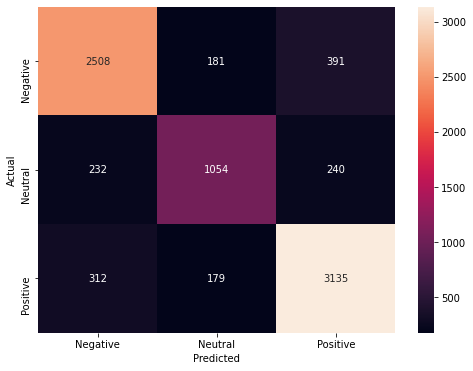

In [45]:
model_logistic.fit(X_train, y_train)
y_pred = model_logistic.predict(X_test)
print("Accurary:", metrics.accuracy_score(y_test,y_pred))
monta_confusion_matrix(y_pred, y_test)

### Random Forest

In [346]:
#model_rf = RandomForestClassifier(n_estimators=200,max_depth=50) best
model_rf = RandomForestClassifier(n_estimators=200) #, max_depth=100

Accurary: 0.7733236151603499


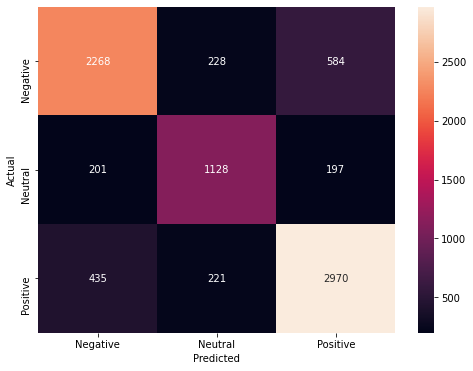

In [347]:
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
print("Accurary:", metrics.accuracy_score(y_test,y_pred))
monta_confusion_matrix(y_pred, y_test)